In [41]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import statistics
import random
import seaborn as sb

from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, f1_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# Data Preparation

In [42]:
def create_subset(size):
    with open('../resources/test_data.json', 'r') as file:
        data = json.load(file)
        
    subset_dictionary = {key: data[key] for key in list(data.keys())[:size]}
    
    with open('../resources/test_data_subset_' + str(size) + '.json', 'w') as file:
        json.dump(subset_dictionary, file, indent=2)
        
    return

In [43]:
create_subset(300)

In [44]:
data_file_path = '../resources/test_data_subset_300.json'
dataframe_file_path = '../resources/data_subset_300.csv'

In [45]:
def check_data():
    df = pd.read_csv(dataframe_file_path)
    
    print("Rows: ", len(df))
    for col in df.columns:
        print(col, ": ", (df[col].isnull().sum()/len(df)) * 100, "%")

In [46]:
with open(data_file_path, 'r') as file:
    data = json.load(file)

symbols = list(data.keys())

metrics = list(data[symbols[0]]['key_metrics_by_form']['10-Q'].keys())

df = pd.DataFrame(columns=['symbol'])

df['stock_change_before'] = None
df['buy'] = None

for metric in metrics:
    df[metric + '_last'] = None
    df[metric + '_sec_last'] = None
    df[metric + '_third_last'] = None

for symbol in symbols:
    dates = list(data[symbol]['facts_by_form']['10-Q']['fileds']) + list(data[symbol]['facts_by_form']['10-K']['fileds'])
    dates = list(set(dates))
    dates.sort()

    if len(dates) < 6:
        continue

    encoded_symbol = LabelEncoder().fit_transform([symbol])[0]

    start_date = datetime.strptime(dates[3], '%Y-%m-%d')
    end_date = datetime.strptime(dates[-2], '%Y-%m-%d')
    random_dates = []

    for _ in range(len(dates) // 2):
        random_date = start_date + (end_date - start_date) * random.random()
        random_dates.append(random_date.strftime('%Y-%m-%d'))

    for date in random_dates:
        date_dt = datetime.strptime(date, '%Y-%m-%d')
        row_values = [encoded_symbol]

        stock_dates = list(data[symbol]['stock_price_history'].keys())
        stock_change_over = []
        stock_change_before = []
        for i, stock_date in enumerate(stock_dates):
            stock_date_dt = datetime.strptime(stock_date, '%Y-%m-%d')

            if (stock_date_dt - date_dt).days < 30 and (stock_date_dt - date_dt).days > 0:
                stock_change_over.append(data[symbol]['stock_price_history'][stock_date]['close'] - data[symbol]['stock_price_history'][stock_dates[i-1]]['close'])
            elif (stock_date_dt - date_dt).days > -30 and (stock_date_dt - date_dt).days < 0:
                stock_change_before.append(data[symbol]['stock_price_history'][stock_date]['close'] - data[symbol]['stock_price_history'][stock_dates[i-1]]['close'])

        if len(stock_change_over) == 0 or len(stock_change_before) == 0:
            continue
        else:
            row_values.append(statistics.median(stock_change_before))

            median_over = statistics.median(stock_change_over)
            if median_over > 0:
                row_values.append(1)
            else:
                row_values.append(0)

        dates_before = [_date for _date in dates if _date <= date]

        for metric in metrics: 
            found_no = 0

            for _date in dates_before[::-1]:
                if found_no == 3:
                    break

                if _date in data[symbol]['key_metrics_by_form']['10-Q'][metric]:
                    if type(data[symbol]['key_metrics_by_form']['10-Q'][metric][_date]) == dict:
                        row_values.append(data[symbol]['key_metrics_by_form']['10-Q'][metric][_date]['val'])
                        found_no += 1
                        continue

                if _date in data[symbol]['key_metrics_by_form']['10-K'][metric]:
                    if type(data[symbol]['key_metrics_by_form']['10-K'][metric][_date]) == dict:
                        row_values.append(data[symbol]['key_metrics_by_form']['10-K'][metric][_date]['val'])
                        found_no += 1
                        continue

            while found_no < 3:
                row_values.append(np.nan)
                found_no += 1

        df.loc[len(df)] = row_values

df.dropna(how='all', inplace=True)

df.to_csv(dataframe_file_path, index=False)

C:\Users\andre\AppData\Local\Temp\ipykernel_24356\2265969160.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[metric + '_sec_last'] = None
C:\Users\andre\AppData\Local\Temp\ipykernel_24356\2265969160.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[metric + '_third_last'] = None
C:\Users\andre\AppData\Local\Temp\ipykernel_24356\2265969160.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colu

In [47]:
test_df = pd.read_csv(dataframe_file_path)

print(f'Rows: {len(test_df)}')
print(f'Columns: {len(test_df.columns)}')

for column in test_df:
    if test_df[column].isnull().all():
        print(column)
        test_df.drop(columns=[column])

test_df.dropna(inplace=True)

print(f'Rows: {len(test_df)}')
print(f'Columns: {len(test_df.columns)}')

Rows: 3007
Columns: 144
Rows: 0
Columns: 144


# Testing the Model

In [48]:
def test_model(name, model, X_test, y_test):
    print(name + ":")
    print("Score: {:.4f}%".format(model.score(X_test, y_test) * 100))
    
    y_pred = model.predict(X_test)
    print("ROC-AUC:", roc_auc_score(y_test, y_pred))
    #print(confusion_matrix(y_test, y_pred))
    #print(classification_report(y_test, y_pred))
    
    return

In [49]:
def test_both_models(lightGBM, XGBoost, X_train, y_train, X_test, y_test):
    lightGBM.fit(X_train, y_train)
    test_model('lightGBM', lightGBM, X_test, y_test)
    
    XGBoost.fit(X_train, y_train)
    test_model('\nXGBoost', XGBoost, X_test, y_test)
    
    return

In [50]:
df = pd.read_csv(dataframe_file_path)
    
X = df.drop('buy', axis=1)
y = df['buy']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Baseline

## We can use 'model.predict_proba' to get the probability of each

In [51]:
lightGBM = LGBMClassifier(objective="binary", random_state=0)
XGBoost = XGBClassifier(objective='binary:logistic')

test_both_models(lightGBM, XGBoost, X_train, y_train, X_test, y_test)

lightGBM:
Score: 62.9568%
ROC-AUC: 0.5887870778267255

XGBoost:
Score: 62.7907%
ROC-AUC: 0.5909309838472835


## Scaling

In [52]:
df = pd.read_csv(dataframe_file_path)
    
X = df.drop('buy', axis=1)
y = df['buy']

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lightGBM = LGBMClassifier(objective="binary", random_state=0)
XGBoost = XGBClassifier(objective='binary:logistic')

test_both_models(lightGBM, XGBoost, X_train, y_train, X_test, y_test)

lightGBM:
Score: 62.6246%
ROC-AUC: 0.5887283406754773

XGBoost:
Score: 63.6213%
ROC-AUC: 0.6054214390602056


## Feature Selection

In [53]:
# m = LGBMClassifier(objective="binary", random_state=0)
# m.fit(X_train, y_train)

# y_pred = m.predict(X_test)
# rocauc = roc_auc_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)
# print("ROC-AUC: %f; F1: %f" % (rocauc, f1))

# thresholds_df = pd.DataFrame()

# thresholds = np.sort(m.feature_importances_)
# for tr in thresholds:
#     sel = SelectFromModel(m, threshold=tr, prefit=True)
#     sel_X_train = sel.transform(X_train.values)
#     #
#     clf = LGBMClassifier(objective="binary", random_state=0)
#     clf.fit(sel_X_train, y_train)
#     #
#     sel_X_test = sel.transform(X_test.values)
#     y_pred = clf.predict(sel_X_test)
#     rocauc = roc_auc_score(y_test, y_pred)
#     f1 = f1_score(y_test, y_pred)
#     right_df = pd.DataFrame([[tr, rocauc]], columns=['threshold', 'roc-auc'])
#     print("Threshold=%s; ROC-AUC: %f; F1: %f" % (tr, rocauc, f1))
#     thresholds_df = pd.concat([thresholds_df, right_df], axis=0, join="outer", ignore_index=True)

# sb.scatterplot(x="threshold", y="roc-auc", data=thresholds_df)

ROC-AUC: 0.605421; F1: 0.498856
Threshold=0.0; ROC-AUC: 0.605421; F1: 0.498856
Threshold=0.0; ROC-AUC: 0.605421; F1: 0.498856
Threshold=0.0; ROC-AUC: 0.605421; F1: 0.498856
Threshold=0.0; ROC-AUC: 0.605421; F1: 0.498856
Threshold=0.0; ROC-AUC: 0.605421; F1: 0.498856
Threshold=0.0; ROC-AUC: 0.605421; F1: 0.498856
Threshold=0.0; ROC-AUC: 0.605421; F1: 0.498856
Threshold=0.0; ROC-AUC: 0.605421; F1: 0.498856
Threshold=0.0; ROC-AUC: 0.605421; F1: 0.498856
Threshold=0.0; ROC-AUC: 0.605421; F1: 0.498856
Threshold=0.0; ROC-AUC: 0.605421; F1: 0.498856
Threshold=0.0; ROC-AUC: 0.605421; F1: 0.498856
Threshold=0.0; ROC-AUC: 0.605421; F1: 0.498856
Threshold=0.0; ROC-AUC: 0.605421; F1: 0.498856
Threshold=0.0; ROC-AUC: 0.605421; F1: 0.498856
Threshold=0.0; ROC-AUC: 0.605421; F1: 0.498856
Threshold=0.0; ROC-AUC: 0.605421; F1: 0.498856
Threshold=0.0; ROC-AUC: 0.605421; F1: 0.498856
Threshold=0.0; ROC-AUC: 0.605421; F1: 0.498856
Threshold=0.0; ROC-AUC: 0.605421; F1: 0.498856
Threshold=0.0; ROC-AUC: 0.60

<Axes: xlabel='threshold', ylabel='roc-auc'>

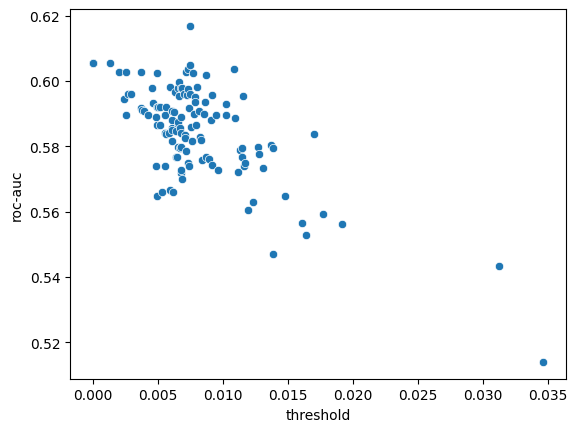

In [54]:
m = XGBClassifier(objective='binary:logistic')
m.fit(X_train, y_train)

y_pred = m.predict(X_test)
rocauc = roc_auc_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("ROC-AUC: %f; F1: %f" % (rocauc, f1))

thresholds_df = pd.DataFrame()

thresholds = np.sort(m.feature_importances_)
for tr in thresholds:
    sel = SelectFromModel(m, threshold=tr, prefit=True)
    sel_X_train = sel.transform(X_train.values)
    #
    clf = XGBClassifier(objective='binary:logistic')
    clf.fit(sel_X_train, y_train)
    #
    sel_X_test = sel.transform(X_test.values)
    y_pred = clf.predict(sel_X_test)
    rocauc = roc_auc_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    right_df = pd.DataFrame([[tr, rocauc]], columns=['threshold', 'roc-auc'])
    print("Threshold=%s; ROC-AUC: %f; F1: %f" % (tr, rocauc, f1))
    thresholds_df = pd.concat([thresholds_df, right_df], axis=0, join="outer", ignore_index=True)

sb.scatterplot(x="threshold", y="roc-auc", data=thresholds_df)

In [55]:
best = thresholds_df.sort_values("roc-auc", ascending=False).iloc[0]
print("Best: \nThreshold = {} \nROC-AUC = {}".format(best["threshold"], best["roc-auc"]))

Best: 
Threshold = 0.007478833664208651 
ROC-AUC = 0.6168986784140968


In [56]:
sel = SelectFromModel(XGBClassifier(objective='binary:logistic'))
sel.fit(X_train, y_train)
selected_attr = X_train.columns[(sel.get_support())]
print(selected_attr, len(selected_attr))

Index(['CurrentRatio_sec_last', 'CurrentRatio_third_last',
       'DebtToAssets_sec_last', 'DebtToAssets_third_last', 'Expenses_sec_last',
       'Revenue_third_last', 'EBIT_last', 'EBIT_sec_last', 'EBIT_third_last',
       'FreeCashFlow_last', 'FreeCashFlow_sec_last', 'FreeCashFlow_third_last',
       'NetDebtToEBITDA_last', 'NetDebtToEBITDA_third_last',
       'IncomeQuality_last', 'IncomeQuality_sec_last',
       'SalesGeneralAndAdministrativeToRevenue_last',
       'SalesGeneralAndAdministrativeToRevenue_sec_last',
       'ReturnOnTangibleAssets_last', 'ReturnOnTangibleAssets_sec_last',
       'ReturnOnTangibleAssets_third_last', 'WorkingCapital_sec_last',
       'WorkingCapital_third_last', 'RevenuePerShare_third_last',
       'InterestDebtPerShare_last', 'InterestDebtPerShare_third_last',
       'ReturnOnEquity_last', 'CapexPerShare_last', 'QuickRatio_sec_last',
       'CashRatio_sec_last', 'CashRatio_third_last', 'ReturnOnAssets_last',
       'ReturnOnAssets_sec_last', 'ReturnOn

In [58]:
attr_to_drop = set(df.columns) - set(selected_attr)
attr_to_drop.remove('buy')

df.drop(attr_to_drop, axis=1, inplace=True)

X = df.drop('buy', axis=1)
y = df['buy']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
lightGBM = LGBMClassifier(objective="binary", random_state=0)
XGBoost = XGBClassifier(objective='binary:logistic')

test_both_models(lightGBM, XGBoost, X_train, y_train, X_test, y_test)

lightGBM:
Score: 62.2924%
ROC-AUC: 0.6079363663727272

XGBoost:
Score: 60.2990%
ROC-AUC: 0.5901439225872621


## Gridsearch

### Need to check which models to use and which params

In [59]:
model_params = {
    'lightGBM': {
        'model': LGBMClassifier(objective="binary", random_state=0),
        'params': {
            'classifier__num_leaves': [n for n in np.arange(2, 10, 1)],
            'classifier__max_depth': [n for n in np.arange(1, 6, 1)],
            'classifier__n_estimators': [n for n in np.arange(50, 151, 25)]
        }
        
    },
    'XGBoost': {
        'model': XGBClassifier(objective='binary:logistic'),
        'params': {
            'classifier__gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4],
            'classifier__learning_rate': [n for n in np.arange(0, 0.7, 0.1)],
            'classifier__max_depth': [n for n in range(4, 10, 1)],
            'classifier__n_estimators': [n for n in range(50, 350, 50)],
            'classifier__reg_alpha': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
            'classifier__reg_lambda': [0.6, 1.0, 1.6,3.2,6.4,12.8,25.6,51.2,102.4,200]
        }
    }
}
"""
    
kf = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=0)

scores = []
for model_name, mp in model_params.items():
    if model_name != 'XGBoost':
        continue
    #pipeline = Pipeline([('smote', SMOTE(random_state=42)), ('classifier', mp['model'])])
    pipeline = Pipeline([('classifier', mp['model'])])
    grid_search = GridSearchCV(pipeline,
                            param_grid=mp['params'],
                            return_train_score=False,
                            cv=kf,
                            n_jobs=-1,
                            verbose=1)

    grid_search.fit(X_train, y_train)
    scores.append({
        'model': model_name,
        'best_score': grid_search.best_score_,
        'best_params': grid_search.best_params_
    })

df = pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])

"""
"""
#Only works if only lightGBM enabled
lightGBM_model = LGBMClassifier(objective="binary", random_state=0, max_depth=df.iloc[0]['best_params']['classifier__max_depth'], n_estimators=df.iloc[0]['best_params']['classifier__n_estimators'], num_leaves=df.iloc[0]['best_params']['classifier__num_leaves'])
lightGBM_model.fit(X_train, y_train)

test_model('LightGBM with gridsearch:', lightGBM_model, X_test, y_test)
"""
"""
XGBoost_model = XGBClassifier(objective='binary:logistic', gamma=df.iloc[0]['best_params']['classifier__gamma'], learning_rate=df.iloc[0]['best_params']['classifier__learning_rate'], max_depth=df.iloc[0]['best_params']['classifier__max_depth'], n_estimators=df.iloc[0]['best_params']['classifier__n_estimators'], reg_alpha=df.iloc[0]['best_params']['classifier__reg_alpha'], n_estimators=df.iloc[0]['best_params']['classifier__reg_lambda'])
XGBoost_model.fit(X_train, y_train)

test_model('XGBoost with gridsearch:', XGBoost_model, X_test, y_test)
"""

"\nXGBoost_model = XGBClassifier(objective='binary:logistic', gamma=df.iloc[0]['best_params']['classifier__gamma'], learning_rate=df.iloc[0]['best_params']['classifier__learning_rate'], max_depth=df.iloc[0]['best_params']['classifier__max_depth'], n_estimators=df.iloc[0]['best_params']['classifier__n_estimators'], reg_alpha=df.iloc[0]['best_params']['classifier__reg_alpha'], n_estimators=df.iloc[0]['best_params']['classifier__reg_lambda'])\nXGBoost_model.fit(X_train, y_train)\n\ntest_model('XGBoost with gridsearch:', XGBoost_model, X_test, y_test)\n"

In [33]:
from skopt import BayesSearchCV

scores = []
for model_name, mp in model_params.items():
    if model_name != 'XGBoost':
        continue
    #pipeline = Pipeline([('smote', SMOTE(random_state=42)), ('classifier', mp['model'])])
    pipeline = Pipeline([('classifier', mp['model'])])
    bayes = BayesSearchCV(pipeline,
                      search_spaces=mp['params'], # same space as GridSearch
                      n_iter=20, cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=0))
    bayes.fit(X_train, y_train)
    scores.append({
        'model': model_name,
        'best_score': bayes.best_score_,
        'best_params': bayes.best_params_
    })

df = pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])

In [35]:
XGBoost_model = XGBClassifier(objective='binary:logistic', gamma=df.iloc[1]['best_params']['classifier__gamma'], learning_rate=df.iloc[1]['best_params']['classifier__learning_rate'], max_depth=df.iloc[1]['best_params']['classifier__max_depth'], n_estimators=df.iloc[1]['best_params']['classifier__n_estimators'], reg_alpha=df.iloc[1]['best_params']['classifier__reg_alpha'], reg_lambda=df.iloc[1]['best_params']['classifier__reg_lambda'])
XGBoost_model.fit(X_train, y_train)

test_model('XGBoost with gridsearch:', XGBoost_model, X_test, y_test)

XGBoost with gridsearch::
Score: 63.9535%
ROC-AUC: 0.6240454398501688


In [36]:
lightGBM_model = LGBMClassifier(objective="binary", random_state=0, max_depth=df.iloc[0]['best_params']['classifier__max_depth'], n_estimators=df.iloc[0]['best_params']['classifier__n_estimators'], num_leaves=df.iloc[0]['best_params']['classifier__num_leaves'])
lightGBM_model.fit(X_train, y_train)

test_model('LightGBM with gridsearch:', lightGBM_model, X_test, y_test)

LightGBM with gridsearch::
Score: 62.7907%
ROC-AUC: 0.607116977514186
